In [61]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
import random

df = pd.read_csv('Data/cobol_pullrequests.csv', usecols=['login','name'])
df = df.rename(columns={'login':'source', 'name':'target'})

edf = pd.read_csv('Data/evolved_dataset.csv')

In [62]:
df

,source,target
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1328,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1329,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1330,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1331,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples


In [63]:
edf

,source,target
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1678,u: raisjn,r: flaechsig/cobolj
1679,u: jbyibm,r: IBM/zOS-Client-Web-Enablement-Toolkit
1680,u: AlbGarciam,r: RuchikaL11/sonar_try
1681,u: shalom938,r: AkinJimoh/aj-soner


In [64]:
n = len(edf) - len(df)
n

350

### Dummy version: takes n samples from the original dataset and duplicates them.

In [65]:
expanded_ds_dummy = pd.concat([df, df.sample(n=n)], ignore_index=True)

In [66]:
expanded_ds_dummy.to_csv('Data/expanded_dataset_dummy.csv', index=False)

### Random version: creates n random new connections.

In [67]:
unique_pairs = [(df['source'][i], df['target'][i]) for i in range(len(df))]
unique_pairs = list(set(unique_pairs))

unique_source = list(set(df['source'].tolist()))
unique_target = list(set(df['target'].tolist()))

candidates = []

for i in range(n):
    while len(candidates) < n:
        candidate = (random.choice(unique_source), random.choice(unique_target))
        if candidate not in unique_pairs:
            unique_pairs.append(candidate)
            candidates.append(candidate)

candidates = pd.DataFrame(candidates, columns=['source', 'target'])

expanded_ds_random = pd.concat([df, candidates], ignore_index=True)


In [68]:
expanded_ds_random

,source,target
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1678,dsh33782,jasmeetsinghbhatia/sonar-scanning-examples
1679,dsh33782,openmainframeproject/cobol-check
1680,agarelik,srikanthprathivadi/jenkinssample
1681,Vadim-Vorotilin,sunny092318/sonarqube


In [69]:
expanded_ds_random.to_csv('Data/expanded_dataset_random.csv', index=False)

In [70]:
def user_user_similarity(adj_matrix, repos):
    
    # Evaluate user-user similarity:
    
    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    return user_user

def create_adjacency_matrix(edge_list):

    # List user and repos

    users = edge_list['source'].unique().tolist()
    repos = edge_list['target'].unique().tolist()

    # Build the adjacency matrix for user - repo (and repo - user) interactions.
    
    adj_matrix = pd.crosstab(edge_list['source'], edge_list['target']).astype(float)
    idx = adj_matrix.columns.union(adj_matrix.index)
    adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0) 
    adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)
    
    return adj_matrix

def graph_metrics(edge_list):
    
    # Evaluate Degree and Eigenvector centralities for each node in a Graph
    G = nx.from_pandas_adjacency(create_adjacency_matrix(edge_list), create_using=nx.DiGraph)
    
    result = pd.DataFrame({'Centrality': nx.pagerank(G), 'Degree': {node:val for (node, val) in G.degree()}})

    # filter users
    result = result[result.index.str.startswith('u: ')]
    
    # Scale values
    for column in result:
        result[column] = result[column].apply(lambda x: (x - result[column].min())/(result[column].max() - result[column].min()))

    return result

def objective(candidate):  
    # Evaluate metrics in terms of star-discrepancy
    return qmc.discrepancy(candidate, method='L2-star',workers=-1)

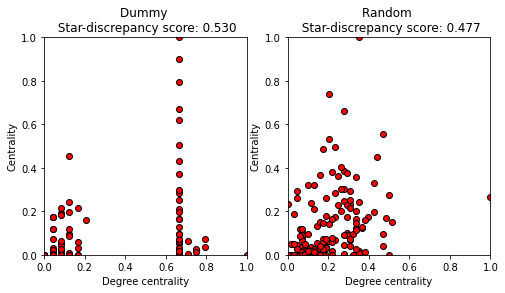

In [73]:
def draw_plot(ax, data, suptitle):
    
    ax = ax or plt.gca()
    
    ax.scatter(data['Degree'], data['Centrality'], edgecolor='k', c='r')
    ax.set_xlabel('Degree centrality')
    ax.set_ylabel('Centrality')
    ax.set_title(f'{suptitle} \n Star-discrepancy score: {objective(data):.3f}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.close()
    
    return ax


def add_prefix(edge_list):
    # Add user (u: ) repo (r: ) indicator for each node
    edge_list['source'] = edge_list['source'].apply(lambda x: 'u: '+x)
    edge_list['target']  = edge_list['target'].apply(lambda x: 'r: '+x)

add_prefix(expanded_ds_dummy)
add_prefix(expanded_ds_random)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1 = draw_plot(ax1, graph_metrics(expanded_ds_dummy), 'Dummy')
ax2 = draw_plot(ax2, graph_metrics(expanded_ds_random), 'Random')
plt.close()

fig